$\newcommand{L}[1]{\| #1 \|}\newcommand{VL}[1]{\L{ \vec{#1} }}\newcommand{R}[1]{\operatorname{Re}\,(#1)}\newcommand{I}[1]{\operatorname{Im}\, (#1)}$

## Convolving with the hemodyamic response function

In [1]:
%matplotlib inline

Start with our usual imports:

In [2]:
import numpy as np
import matplotlib.pyplot as plt

## Using scipy

*Scipy* is a large library of scientific routines that builds on top of numpy.

You can think of numpy as being a subset of MATLAB, and numpy + scipy as being
as being roughly equivalent to MATLAB plus the MATLAB toolboxes.

Scipy has many sub-packages, for doing things like reading MATLAB `.mat`
files (`scipy.io`) or working with sparse matrices (`scipy.sparse`). We
are going to be using the functions and objects for working with statistical
distributions in `scipy.stats`:

In [3]:
import scipy.stats

`scipy.stats` contains objects for working with many different
distributions. We are going to be working with `scipy.stats.gamma`, which
implements the [gamma distribution](https://en.wikipedia.org/wiki/Gamma_distribution).

In [4]:
from scipy.stats import gamma

In particular we are interested in the [probability density function](https://en.wikipedia.org/wiki/Probability_density_function) (PDF) of the
gamma distribution.

Because this is a function, we need to pass it an array of values at
which it will evaluate.

We can also pass various parameters which change the shape, location and width
of the gamma PDF. The most important is the first parameter (after the input
array) known as the [shape parameter](https://en.wikipedia.org/wiki/Shape_parameter) ($k$ in the
[wikipedia page on gamma distributions](https://en.wikipedia.org/wiki/Gamma_distribution)).

First we chose some x values at which to sample from the gamma PDF:

In [5]:
x = np.arange(0, 25, 0.1)

Next we plot the gamma PDF for shape values of 2, 4, 8, 12.

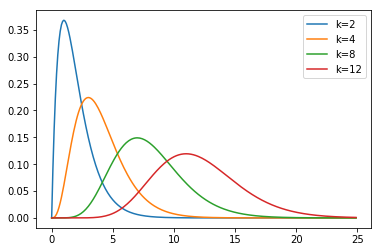

In [6]:
plt.plot(x, gamma.pdf(x, 2), label='k=2')
plt.plot(x, gamma.pdf(x, 4), label='k=4')
plt.plot(x, gamma.pdf(x, 8), label='k=8')
plt.plot(x, gamma.pdf(x, 12), label='k=12')
plt.legend()

# Constructing a hemodynamic response function

We can use these gamma functions to construct a continuous function that is
close to the hemodynamic response we observe for a single brief event in the
brain.

Our function will accept an array that gives the times we want to calculate
the HRF for, and returns the values of the HRF for those times.  We will
assume that the true HRF starts at zero, and gets to zero sometime before 35
seconds.

We’re going to try using the sum of two [gamma distribution](https://en.wikipedia.org/wiki/Gamma_distribution) probability density
functions.

Here is one example of such a function:

In [7]:
def hrf(times):
    """ Return values for HRF at given times """
    # Gamma pdf for the peak
    peak_values = gamma.pdf(times, 6)
    # Gamma pdf for the undershoot
    undershoot_values = gamma.pdf(times, 12)
    # Combine them
    values = peak_values - 0.35 * undershoot_values
    # Scale max to 0.6
    return values / np.max(values) * 0.6

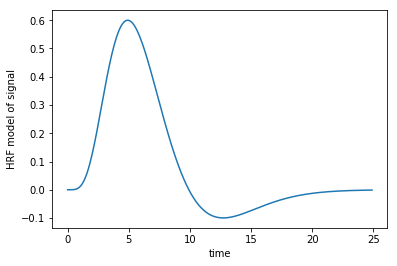

In [8]:
plt.plot(x, hrf(x))
plt.xlabel('time')
plt.ylabel('HRF model of signal')

We can sample from the function, to get the estimates at the times of our TRs.
Remember, the TR is 2.5 for our example data, meaning the scans were 2.5
seconds apart.

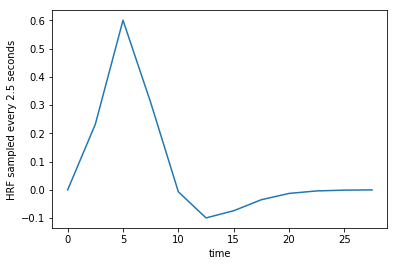

In [9]:
TR = 2.5
tr_times = np.arange(0, 30, TR)
hrf_at_trs = hrf(tr_times)
len(hrf_at_trs)
plt.plot(tr_times, hrf_at_trs)
plt.xlabel('time')
plt.ylabel('HRF sampled every 2.5 seconds')

We can use this to convolve our neural (on-off) prediction.  This will give us
a hemodynamic prediction, under the linear-time-invariant assumptions of the
convolution.  Download `stimuli.py` if you don’t have it already.

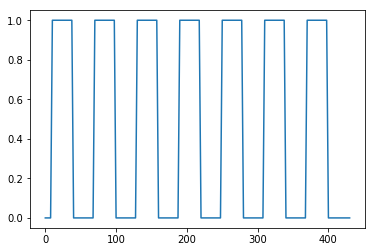

In [10]:
from stimuli import events2neural
n_vols = 173
neural_prediction = events2neural('ds114_sub009_t2r1_cond.txt',
                                  TR, n_vols)
all_tr_times = np.arange(173) * TR
plt.plot(all_tr_times, neural_prediction)

When we convolve, the output is length N + M-1, where N is the number of
values in the vector we convolved, and M is the length of the convolution
kernel (`hrf_at_trs` in our case).  For a reminder of why this is, see the
[tutorial on convolution](https://matthew-brett.github.io/teaching/on_convolution.html).

In [11]:
convolved = np.convolve(neural_prediction, hrf_at_trs)
N = len(neural_prediction)  # M == n_vols == 173
M = len(hrf_at_trs)  # M == 12
len(convolved) == N + M - 1

True

This is because of the HRF convolution kernel falling off the end of the input
vector. The value at index 172 in the new vector refers to time 172 \* 2.5 =
430.0 seconds, and value at index 173 refers to time 432.5 seconds, which is
just after the end of the scanning run. To retain only the values in the new
hemodynamic vector that refer to times up to (and including) 430s, we can just
drop the last `len(hrf_at_trs) - 1 == M - 1` values:

In [12]:
n_to_remove = len(hrf_at_trs) - 1
convolved = convolved[:-n_to_remove]

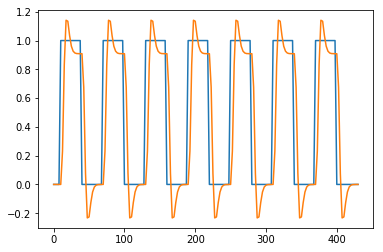

In [13]:
plt.plot(all_tr_times, neural_prediction)
plt.plot(all_tr_times, convolved)

For our future use, let us save our convolved time course to a numpy text
file:

In [14]:
# Save the convolved time course to 6 decimal point precision
np.savetxt('ds114_sub009_t2r1_conv.txt', convolved, fmt='%2.6f')
back = np.loadtxt('ds114_sub009_t2r1_conv.txt')
# Check written data is within 0.000001 of original
np.allclose(convolved, back, atol=1e-6)

True

<!-- vim:ft=rst -->
<!-- Course -->
<!-- BIC -->
<!-- Python distributions -->
<!-- Version control -->
<!-- Editors -->
<!-- Python and common libraries -->
<!-- IPython -->
<!-- Virtualenv and helpers -->
<!-- Pypi and packaging -->
<!-- Mac development -->
<!-- Windows development -->
<!-- Nipy and friends -->
<!-- FMRI datasets -->
<!-- Languages -->
<!-- Imaging software -->
<!-- Installation -->
<!-- Tutorials -->
<!-- MB tutorials -->
<!-- Ideas -->
<!-- Psych-214 -->
<!-- People -->
<!-- Licenses -->
<!-- Neuroimaging stuff -->
<!-- OpenFMRI projects -->
<!-- Unix -->
<!-- Substitutions -->